# GAIA Dataset

Just some simple code to get yourself familiarized with the datasets.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py

data_dir = 'data/'

I have created a file that just contains the wavelength values corresponding to the pixels in our spectra.

In [2]:
wave_grid = np.load(os.path.join(data_dir, 'gaia_wavegrid.npy'))

print('These spectra contain %i pixels' % (len(wave_grid)), 
      'in the wavelength range: %0.1f - %0.1f Angstrom.' % (min(wave_grid), max(wave_grid)))

These spectra contain 800 pixels in the wavelength range: 8460.1 - 8699.8 Angstrom.


## Observed Data

This data file contains the spectra taken from the telescope (the observations) as well as the label estimates from the GAIA pipeline. These estimates are not perfect, but sometimes we rely on them as a sanity check for our own predictions.

In [3]:
fn_obs = 'gaia_observed.h5'

with h5py.File(os.path.join(data_dir, fn_obs), 'r') as f:
    # Display the different "datasets" in the data file
    print('This data file contains:')
    print('\t| %15s | %15s |' % ('Dataset', 'Shape' ))
    for k in f.keys():
        print('\t| %15s | %15s |' % (k, f[k].shape))
        
    # You can load entire datasets into memory,
    # which is useful when doing analyses like this.
    spectra_obs = f['spectra train'][:]
    teff_obs = f['teff train'][:]

This data file contains:
	|         Dataset |           Shape |
	|           Notes |            (1,) |
	|     alpha train |       (867125,) |
	|       alpha val |         (3000,) |
	|       feh train |       (867125,) |
	|         feh val |         (3000,) |
	|      logg train |       (867125,) |
	|        logg val |         (3000,) |
	| source ID train |       (867125,) |
	|   source ID val |         (3000,) |
	|   spectra train |   (867125, 800) |
	|     spectra val |     (3000, 800) |
	|      teff train |       (867125,) |
	|        teff val |         (3000,) |


Let's plot a spectrum just to get an idea of what they look like.

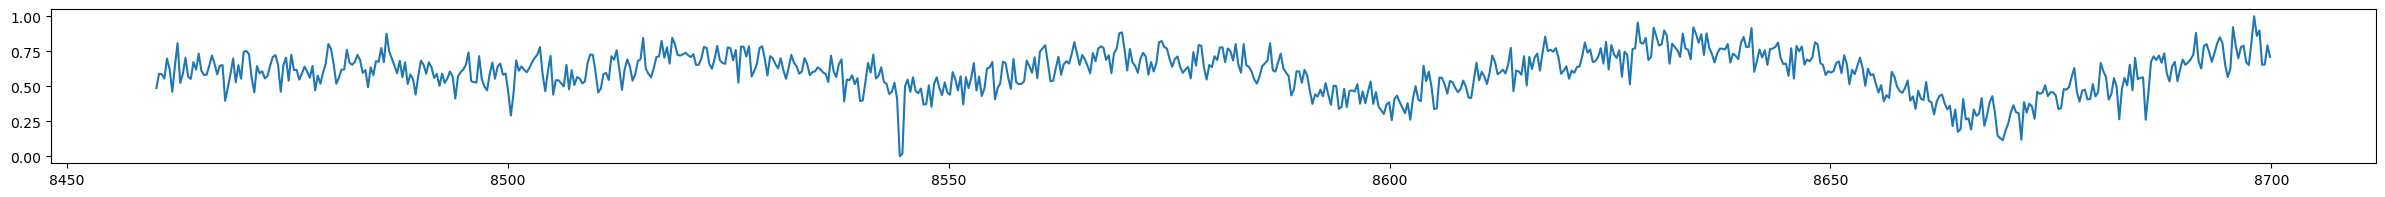

In [4]:
indx = 0

plt.figure(figsize=(30,2))
plt.plot(wave_grid, spectra_obs[indx])
plt.show()

## Synthetic Data

This data file contains the synthetically generated spectra. The labels associated with each spectrum in this domain are considered "ground truths".

In [5]:
fn_synth = 'gaia_grid.h5'

with h5py.File(os.path.join(data_dir, fn_synth), 'r') as f:
    # Display the different "datasets" in the data file
    print('This data file contains:')
    print('\t| %15s | %15s |' % ('Dataset', 'Shape' ))
    for k in f.keys():
        print('\t| %15s | %15s |' % (k, f[k].shape))

    spectra_synth = f['spectra train'][:]
    teff_synth = f['teff train'][:]

This data file contains:
	|         Dataset |           Shape |
	|           Notes |            (1,) |
	|     alpha train |        (48373,) |
	|       alpha val |         (3000,) |
	|       feh train |        (48373,) |
	|         feh val |         (3000,) |
	|      logg train |        (48373,) |
	|        logg val |         (3000,) |
	|   spectra train |    (48373, 800) |
	|     spectra val |     (3000, 800) |
	|      teff train |        (48373,) |
	|        teff val |         (3000,) |


Let's also take a look at a synthetic spectrum.

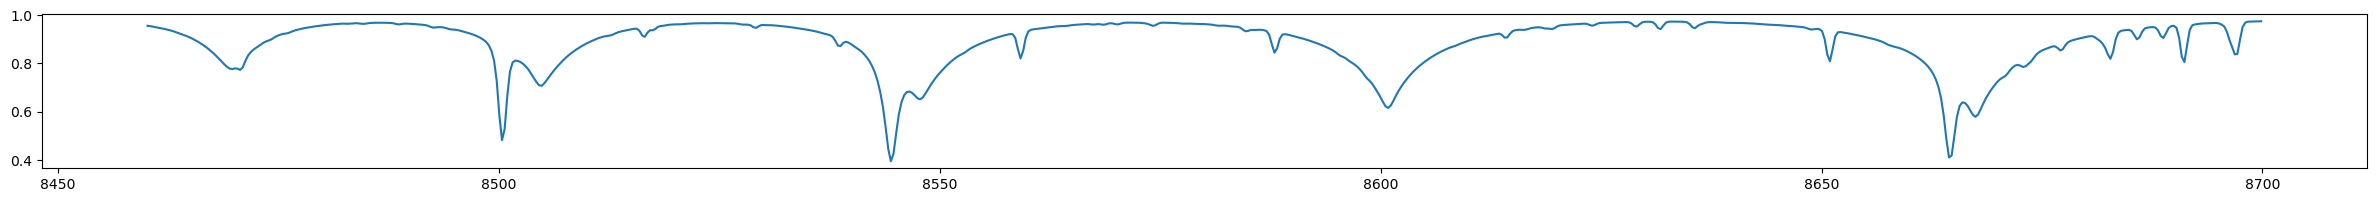

In [6]:
indx = 100

plt.figure(figsize=(30,2))
plt.plot(wave_grid, spectra_synth[indx])
plt.show()

Much cleaner, eh?

## Dataset Comparisons

There are numerous differences between the two domains of data and they are important to investigate in order to get an understanding of the problem we are trying to solve.

### Label Distributions

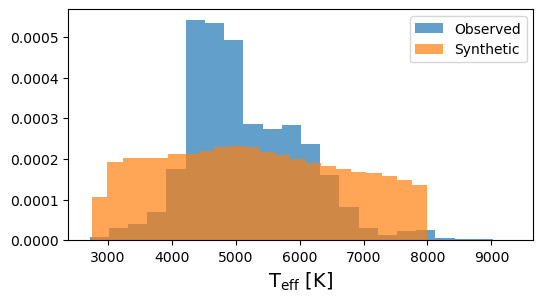

In [7]:
plt.figure(figsize=(6,3))

plt.hist(teff_obs, label='Observed', alpha=0.7, 
         density=True, bins=len(np.unique(teff_synth)))
plt.hist(teff_synth, label='Synthetic', alpha=0.7, 
         density=True, bins=len(np.unique(teff_synth)))
plt.xlabel('T$_{\mathrm{eff}}$ [K]', fontsize=14)
plt.legend()

plt.show()

You could do a similar comparison of the other labels as well.

### t-SNE

Our group has often used t-SNE analyses to compare different domains of data. If you're not familiar with them, take a look at this [video](https://www.youtube.com/watch?v=NEaUSP4YerM)!

Here we will compare the spectra from the two domains.

In [8]:
from sklearn.manifold import TSNE

def run_tsne(data_a, data_b, perplex):

    m = len(data_a)

    # Combine data into a single array
    t_data = np.row_stack((data_a,data_b))

    # Convert data to float64 matrix. float64 is need for bh_sne
    t_data = np.asarray(t_data).astype('float64')
    t_data = t_data.reshape((t_data.shape[0], -1))

    # Run t-SNE    
    vis_data = TSNE(n_components=2, perplexity=perplex).fit_transform(t_data)
    
    # Separate 2D into x and y axes information
    vis_x_a = vis_data[:m, 0]
    vis_y_a = vis_data[:m, 1]
    vis_x_b = vis_data[m:, 0]
    vis_y_b = vis_data[m:, 1]
    
    return vis_x_a, vis_y_a, vis_x_b, vis_y_b

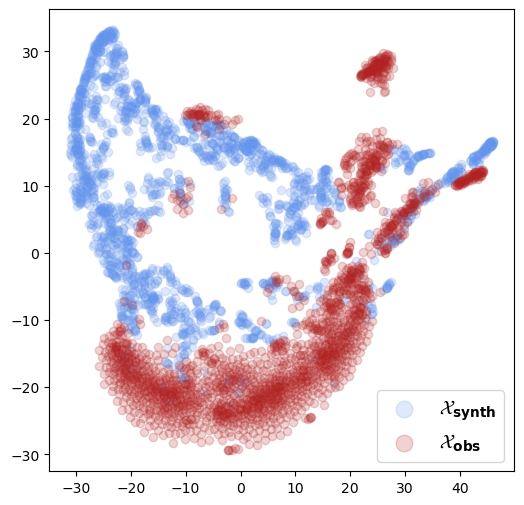

In [9]:
# Perform t-SNE on a subsample of the spectra
num_samples = 2000
tx_synth, ty_synth, tx_obs, ty_obs = run_tsne(spectra_synth[:num_samples], 
                                              spectra_obs[:num_samples], 
                                              perplex=80)

# Plot them together
plt.figure(figsize=(6,6))
plt.scatter(tx_synth, ty_synth,
            label=r'$\mathbf{\mathcal{X}_{synth}}$',
            marker='o', c='cornflowerblue', alpha=0.2)
plt.scatter(tx_obs, ty_obs,
            label=r'$\mathbf{\mathcal{X}_{obs}}$',
            marker='o', c='firebrick', alpha=0.2)
plt.legend(fontsize=14, frameon=True, fancybox=True, markerscale=2.)
plt.show()

You can see that there is very little overlap between the two domains. Our objective is to either bridge the gap between the synthetic and observed data or build a pipeline that is flexible enough to look past the gap between the two domains.

## Dataloaders

To train a neural network with PyTorch, it is useful to create dataloaders for your datasets. This is a simple example of one, but you will find a more complicated version in `utils/data_loader.py`

In [10]:
import torch

class SpectraDatasetSimple(torch.utils.data.Dataset):
    
    """
    Dataset loader for the spectral datasets.
    """

    def __init__(self, data_file, dataset, label_keys):
        
        self.data_file = data_file
        self.dataset = dataset.lower()
        self.label_keys = label_keys
                        
    def __len__(self):
        with h5py.File(self.data_file, "r") as f:    
            num_spectra = len(f['spectra %s' % self.dataset])
        return num_spectra
    
    def __getitem__(self, idx):
        
        with h5py.File(self.data_file, "r") as f: 
                
            # Load spectrum
            spectrum = f['spectra %s' % self.dataset][idx]
            spectrum[spectrum<-1] = -1.
            spectrum = torch.from_numpy(spectrum.astype(np.float32))
            
            # Load target stellar labels
            data_keys = f.keys()
            labels = []
            for k in self.label_keys:
                data_key = k + ' %s' % self.dataset
                if data_key in data_keys:
                    labels.append(f[data_key][idx])
                else:
                    labels.append(np.nan)
            labels = torch.from_numpy(np.asarray(labels).astype(np.float32))
            
        # Return full spectrum and target labels
        return {'spectrum':spectrum,
                'labels':labels}

Let's test this out for our synthetic data.

In [11]:
# Create dataset for loading spectra
synth_data_file = os.path.join(data_dir, 'gaia_grid.h5')
batch_size = 16

synth_train_dataset = SpectraDatasetSimple(synth_data_file, 
                                            dataset='train', 
                                            label_keys=['teff', 'feh', 'logg', 'alpha'])

synth_train_dataloader = torch.utils.data.DataLoader(synth_train_dataset,
                                                      batch_size=batch_size, 
                                                      shuffle=False, 
                                                      num_workers=1,
                                                      pin_memory=True)

This dataloader will allow us to iterate through the samples to grab batches of training samples.

In [12]:
for i, batch in enumerate(synth_train_dataloader):
    
    # Stop test
    if i>10:
        break

print('| %10s | %22s |' % ('Key', 'Shape' ))
for k in batch.keys():
    print('| %10s | %22s |' % (k, batch[k].shape))

|        Key |                  Shape |
|   spectrum |  torch.Size([16, 800]) |
|     labels |    torch.Size([16, 4]) |
